# **CNN** and **GA** on Image Classification

**Objective:** Classify the bird species that appear on an image based on the use of a Convolutional Neural Network model (CNN).

**Summary of the dataset features:**
- Bird Species: 250;
- Training  Images:  35215  (not  balanced,  however  has  at  least  100 
training  image  files  per species);
- Validation Images: 1250 (5 per species);
- Test Images: 1250 (5 per species);
- Images Size: 224 x 224 x 3 color channels in jpg format;
- Species gender: 80% of total images are of male while the remaining 20% are of female -the classifier may not perform as well on female specie images.



 > Note: To run the genetic algorithm, just run all the cells to the "1º Model", and you can now jump to the cell that says "GA-Genetic Algorithm"

#### Configuration of GPU mode:
> Primeiro ir à **tab** Runtime -> Change runtime type -> Hardware accelarator = GPU

In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name()) # Se der "/device:GPU:0" foi atribuida uma GPU.
def config_GPU():
 !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
 !pip install gputil
 !pip install psutil
 !pip install humanize
 import psutil
 import humanize
 import os
 import GPUtil as GPU
 GPUs = GPU.getGPUs()
 # only one GPU on Colab and isn’t guaranteed
 gpu = GPUs[0]

 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

#RETIRAR de comentário a chamda à função para configura GPU!!!
config_GPU()

/device:GPU:0
  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=36d55204fb7125d9382a54fcb03e1be03c4fd307cd001c1fae1240cfa74bc9b6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 25.9 GB  | Proc size: 920.9 MB
GPU RAM Free: 15931MB | Used: 349MB | Util   2% | Total 16280MB


# CNN - Convolutional Neural Network
> Necessary Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D,Dropout, Dense, Flatten, experimental

#backend
from keras import backend as K



### **Loading** your Dataset. 
> It is necessary to place the zip on the Google drive.<br/><br/>
> Give access to the database on the google drive.<br/><br/>
> **Note**: You have to change the path to the dataset on  ` !unzip ` command.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#unzip the dataset
!unzip "/content/drive/My Drive/CN_TP1/dataset.zip" 
#!ls

Streaming output truncated to the last 5000 lines.
  inflating: train/TOUCHAN/080.jpg   
  inflating: train/TOUCHAN/081.jpg   
  inflating: train/TOUCHAN/082.jpg   
  inflating: train/TOUCHAN/083.jpg   
  inflating: train/TOUCHAN/084.jpg   
  inflating: train/TOUCHAN/085.jpg   
  inflating: train/TOUCHAN/086.jpg   
  inflating: train/TOUCHAN/087.jpg   
  inflating: train/TOUCHAN/088.jpg   
  inflating: train/TOUCHAN/089.jpg   
  inflating: train/TOUCHAN/090.jpg   
  inflating: train/TOUCHAN/091.jpg   
  inflating: train/TOUCHAN/092.jpg   
  inflating: train/TOUCHAN/093.jpg   
  inflating: train/TOUCHAN/094.jpg   
  inflating: train/TOUCHAN/095.jpg   
  inflating: train/TOUCHAN/096.jpg   
  inflating: train/TOUCHAN/097.jpg   
  inflating: train/TOUCHAN/098.jpg   
  inflating: train/TOUCHAN/099.jpg   
  inflating: train/TOUCHAN/100.jpg   
  inflating: train/TOUCHAN/101.jpg   
  inflating: train/TOUCHAN/102.jpg   
  inflating: train/TOUCHAN/103.jpg   
  inflating: train/TOUCHAN/104.jpg   

> Let's define **constants**


In [2]:
#some parameteres for the loader
#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network 
batch_size = 32#64 
img_height = 224
img_width = 224

num_classes = 250
epochs=10
checkpoint_filepath = 'save_best_epoch.h5' #used on callback3



> **Standardize** the data.
  - Normalização dos valores RGB de `[0,255]`para `[0,1]`.<br/>
  - Data Augmentation.<br/>

> **Loading** data for **train ,validation and test**.


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    #brightness_range=[0.1, 0.5],
    shear_range = 0.1,
    zoom_range = 0.1,
    dtype=np.float32,
    rotation_range=40
)
    #zoom_range = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255,dtype=np.float32)
test_datagen = ImageDataGenerator(rescale = 1./255,dtype=np.float32)



In [22]:
train_ds = train_datagen.flow_from_directory(  
  "train",
  target_size = (img_height, img_width),
  seed=123,
  batch_size = batch_size,
  class_mode = 'categorical')

val_ds = val_datagen.flow_from_directory( 
    "valid",
    target_size = (img_height, img_width),
    seed=123,
    batch_size = batch_size,
    class_mode = 'categorical')

test_ds = test_datagen.flow_from_directory(
     "test",
    target_size = (img_height, img_width),
    seed=123,
    batch_size = batch_size,
    class_mode = 'categorical')


Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


>  **Visualize** the data:

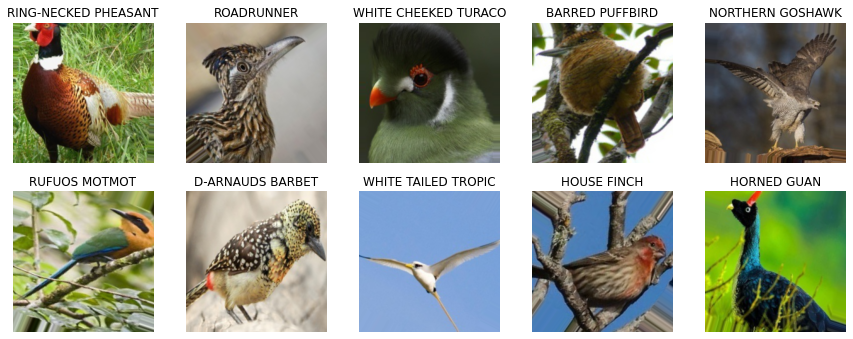

In [8]:
names= {v: k for k, v in train_ds.class_indices.items()} 
plt.figure(figsize=(15, 15))

x,y = train_ds.next()
for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(x[i])
    pos_name, = np.where(np.isclose(y[i], 1.0))
    plt.title(names[pos_name[0]])
    plt.axis("off")

>Configure **callbacks**  for CNN Models

---



In [9]:
#Available callbacks on  https://keras.io/api/callbacks/
#cb1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) # se estiver a mais de 5 epochs a ter o mesmo grau de val_loss pára!
cb2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

#cb2 = tf.keras.callbacks.ProgbarLogger(count_mode="samples", stateful_metrics=None)
cb3 = tf.keras.callbacks.ModelCheckpoint(
    filepath= checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

cb4 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2) #se apartir de 2 epochs a loss não descer,o learning rate diminui em 10%.
my_callbacks=[
    cb3,cb4
]

### 1º Model
 > Sequential API <br />
 > It is common for a convolutional layer to learn from 32 to 512 filters in parallel for a given input.<br /><br />
 **Train** a model.

In [ ]:

model = Sequential([
# 32 filtros, 3 kernel 3x3 
  layers.Conv2D(32,(3,3),input_shape=(img_height, img_width,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64,(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128,(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256,(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),                      #tranforma num vetor
  
  layers.Dense(512, activation='relu'),  # hidden layer
  layers.Dropout(0.1),    
  layers.Dense(512, activation='relu'),  # hidden layer
  #layers.Dropout(0.1),                    # serve para diminuir overfitting, ou seja , não se adaptar demasiado ao dataset treino.
  layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

history1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=my_callbacks,
  batch_size=batch_size,
  verbose=1
)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 256)      

 > **Visualize** the train_results with validation data.

In [ ]:

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


> Evaluate the model

In [ ]:

# BEST EPOCH
#model.load_weights(checkpoint_filepath)

#predictions = model.predict(test_ds)

result = model.evaluate(test_ds)

40/40 [==============================] - 2s 56ms/step - loss: 1.1050 - accuracy: 0.7456


### 2º Model 
 > Sequential API <br />
  


In [23]:

data_augmentation = keras.Sequential(
  [
    #layers.experimental.preprocessing.RandomFlip("horizontal", 
    #                                             input_shape=(img_height, 
    #                                                          img_width,
    #                                                          3)),
    layers.experimental.preprocessing.RandomRotation(0.1),   
    layers.experimental.preprocessing.RandomContrast(0.1),
    #layers.experimental.preprocessing.Rescaling(1./255),
    #layers.experimental.preprocessing.Resizing(255, 255)
  ]
)

#Tranferir para o ImageDataGenerator.


In [ ]:

model2 = Sequential([
  data_augmentation,
  layers.Conv2D(32,(3,3), input_shape=(img_height, img_width,3),padding='same', activation='relu'),#32
  layers.MaxPooling2D( pool_size=(2, 2)),
  layers.Conv2D(64,(3,3), padding='same', activation='relu'),#64
  layers.MaxPooling2D( pool_size=(2, 2)),
  layers.Conv2D(128,(3,3), padding='same', activation='relu'),#128
  layers.MaxPooling2D(),
  layers.Conv2D(256,(3,3), padding='same', activation='relu'),#256
  layers.MaxPooling2D( pool_size=(2, 2)),
  layers.Conv2D(400,(3,3), padding='same', activation='relu'),#256
  layers.MaxPooling2D( pool_size=(2, 2)),
  layers.Flatten(),
  #hiden layers
  layers.Dense(528, activation='relu'),#512
  layers.Dropout(0.1),
  #layers.Dense(512, activation='relu'), #512
  #layers.Dropout(0.1),
  #layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax'),
])

#Atenção, se o learning rate for muito baixo, podemos convergir para um ponto local e ocorrer overfit.
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),#'adam',
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#model2.summary()

#Fit with dataset of train
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=my_callbacks,
  batch_size=batch_size,
  verbose=1
)


> Tunning some parameters with kerastuner

In [ ]:
 results = model2.evaluate(test_ds,return_dict=True,verbose=1)

40/40 [==============================] - 2s 51ms/step - loss: 0.9337 - accuracy: 0.7472


In [ ]:
### install dependencies
!pip install keras-tuner

In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    data_augmentation,                       
    layers.Conv2D(
        #filters=hp.Int('Conv_1_filter', min_value=32, max_value=256, step=16),
        #kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        filters=32,
        kernel_size=(3,3),
        activation='relu',
        input_shape=(img_height,img_width,3)
    ),
    layers.MaxPooling2D( pool_size=(2, 2)),
    layers.Conv2D(
        #filters=hp.Int('Conv_2_filter', min_value=64, max_value=256, step=16),
        #kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        filters=64,
        kernel_size=(3,3),
        activation='relu',
        input_shape=(img_height,img_width,3)
    ),
    layers.MaxPooling2D( pool_size=(2, 2)),
    layers.Conv2D(
        #filters=hp.Int('Conv_3_filter', min_value=128, max_value=256, step=16),
        #kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        input_shape=(img_height,img_width,3)
    ),
    layers.MaxPooling2D( pool_size=(2, 2)),
    layers.Conv2D(
        #filters=hp.Int('Conv_4_filter', min_value=128, max_value=256, step=16),
        #kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        input_shape=(img_height,img_width,3)
    ),
    layers.MaxPooling2D( pool_size=(2, 2)),
    layers.Conv2D(
        filters=hp.Int('Conv_5_filter', min_value=32, max_value=512, step=16),
        #kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
        #filters=256,
        kernel_size=(3,3),
        activation='relu',
        input_shape=(img_height,img_width,3)
    ),
    layers.MaxPooling2D( pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(
        units=hp.Int('Dense_1_units', min_value=256, max_value=1024, step=16),
        activation='relu'
    ),
    layers.Dropout(0.1),
    layers.Dense(
        units=hp.Int('Dense_2_units', min_value=256, max_value=1024, step=16),
        activation='relu'
    ),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3])), #1e-2,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=15,directory='output',project_name=" BIRDS_Model")


tuner_search.search(train_ds,validation_data=val_ds,epochs=3)

Trial 13 Complete [00h 06m 24s]
val_accuracy: 0.451200008392334

Best val_accuracy So Far: 0.7088000178337097
Total elapsed time: 01h 11m 01s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
#get best model
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
#Put the parameters on model 2 .
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

 > **Visualize** the train_results.

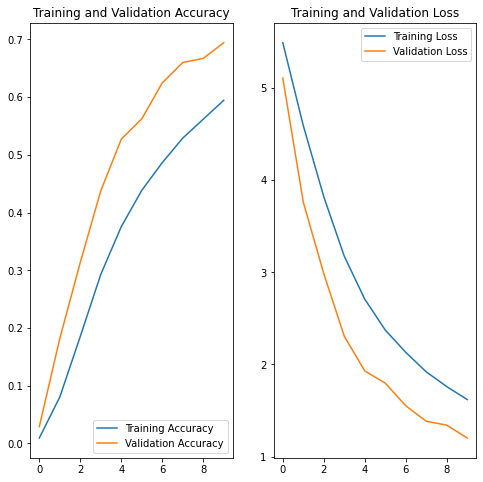

In [ ]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> **Evaluate** the model




In [ ]:

# BEST EPOCH
#model2.load_weights(checkpoint_filepath)

#predictions = model2.predict(test_ds)
#result = model2.evaluate(test_ds)


### 3º Model 
>Funtional API

In [1]:
# use functional API to build cnn layers
input = keras.Input(shape=(img_height, img_width,3))
y = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu')(input)
y = layers.MaxPooling2D(pool_size=(2, 2))(y)
y = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y)
y = layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y)
y = layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y)
y = layers.Flatten()(y)# image to vector before connecting to dense layer

y=layers.Dense(512, activation='relu')(y)
y=layers.Dropout(0.3)(y)
#y=layers.Dense(512, activation='relu')(y)
#y = layers.Dropout(0.1)(y)
output = layers.Dense(num_classes, activation='softmax')(y)


# build the model by supplying inputs/outputs
model3 = keras.models.Model(inputs=input, outputs=output)
model3.compile(optimizer=tf.keras.optimizers.Adagrad(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model with input images and labels
history3 = model3.fit(train_ds,validation_data=val_ds,epochs=epochs,batch_size=batch_size)

#model3.summary()

NameError: ignored

> **Evaluate** the model

In [ ]:

# BEST EPOCH
#model3.load_weights(checkpoint_filepath)

#predictions = model3.predict(test_ds)
result = model3.evaluate(test_ds)

40/40 [==============================] - 2s 49ms/step - loss: 1.0378 - accuracy: 0.7472


### Transfer learning 
Pre-Trained Models <br/>
To see all the models that can be applied go to: https://keras.io/api/applications/ <br />

> 1- Define a function to use the preprocessing functions of the pre-trained networks



In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def pre_process(img_shape, function_pre_processing): 
    img_datagen = ImageDataGenerator(
        preprocessing_function = function_pre_processing,
        horizontal_flip = True,
        rotation_range=40,
        zoom_range = 0.1
    )

    train_ds = img_datagen.flow_from_directory(
        "train",
        target_size = img_shape, 
        batch_size = batch_size,
        class_mode = 'categorical'
    )

    val_ds = img_datagen.flow_from_directory(
        "valid",
        target_size = img_shape, 
        batch_size = batch_size,
        class_mode = 'categorical'
    )
    
    test_ds = img_datagen.flow_from_directory(
        "test",
        target_size = img_shape, 
        batch_size = batch_size,
        class_mode = 'categorical'
    )
    return train_ds, val_ds, test_ds

#### ResNet50

In [19]:
#!pip install resnet50-pynq
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input 



train_ds, val_ds, test_ds = pre_process((img_height, img_width),preprocess_input)

resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
   # pooling=(2,2),
    input_shape = (img_height, img_width,3),
    classes=num_classes,
    classifier_activation="softmax",
)
for layer in resnet.layers:
    layer.trainable = False

x = Flatten()(resnet.output)


#Add the fully-connected layers 

x = Dense(528, activation='relu', name='fc1')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc2')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc3')(x)

x = Dense(num_classes, activation='softmax', name='predicts')(x)

resnet_model = tf.keras.Model(inputs=resnet.input, outputs=x)

resnet_model.compile(optimizer=tf.keras.optimizers.Adagrad(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
resnet_model.summary()

#resnet_history = resnet_model.fit(train_ds, validation_data = val_ds, steps_per_epoch = 100, epochs = 10)
resnet_history = resnet_model.fit(train_ds, validation_data = val_ds,   epochs=epochs
  )#callbacks=my_callbacks)



K.clear_session()


Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256  

In [27]:
results =resnet_model.evaluate(test_ds,return_dict=True,verbose=1)

40/40 [==============================] - 15s 366ms/step - loss: 6.0087 - accuracy: 0.0032


In [10]:
!ls
#resnet_model.save('resnet')

drive  sample_data  test  train  valid


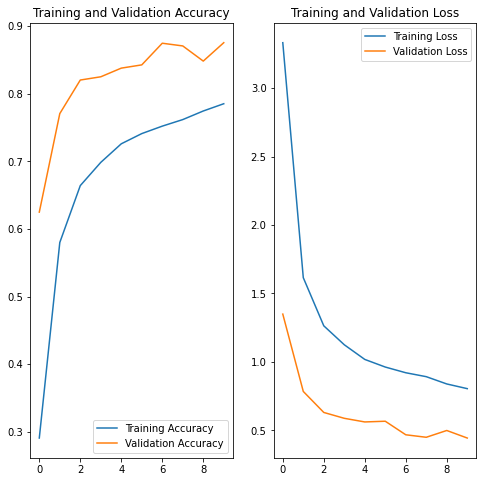

In [ ]:

acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> **Evaluate** the model

In [ ]:
# BEST EPOCH
#resnet_model.load_weights(checkpoint_filepath)

#predictions = resnet_model.predict(test_ds)
#result = resnet_model.evaluate(test_ds)

#### VGG16 

In [28]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 


train_ds, val_ds, test_ds = pre_process((img_height, img_width),preprocess_input)

vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
   # pooling=(2,2),
    input_shape = (img_height, img_width,3),
    classes=num_classes,
    classifier_activation="softmax",
)
#manter as camadas non treinable
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

#Add the fully-connected layers 

x = Dense(528, activation='relu', name='fc1')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc2')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc3')(x)

x = Dense(num_classes, activation='softmax', name='predicts')(x)

vgg16_model = tf.keras.Model(inputs=vgg.input, outputs=x)

vgg16_model.compile(optimizer=tf.keras.optimizers.Adagrad(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


vgg16_model.summary()

vgg16_history = vgg16_model.fit(train_ds, validation_data = val_ds, epochs=epochs,
  callbacks=my_callbacks,
  batch_size=batch_size,
  verbose=1 )

vgg16_model.save('vgg')

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_____________________________________________________________

In [15]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 


#train_ds, val_ds, test_ds = pre_process((img_height, img_width),preprocess_input)

vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
   # pooling=(2,2),
    input_shape = (img_height, img_width,3),
    classes=num_classes,
    classifier_activation="softmax",
)
#manter as camadas non treinable
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

#Add the fully-connected layers 

x = Dense(528, activation='relu', name='fc1')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc2')(x)

x = Dense(num_classes, activation='softmax', name='predicts')(x)

vgg16_model2 = tf.keras.Model(inputs=vgg.input, outputs=x)

vgg16_model2.compile(optimizer=tf.keras.optimizers.Adagrad(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


vgg16_model2.summary()

vgg16_history2 = vgg16_model.fit(train_ds, validation_data = val_ds, epochs=epochs,
  callbacks=my_callbacks,
  batch_size=batch_size,
  verbose=1 )


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

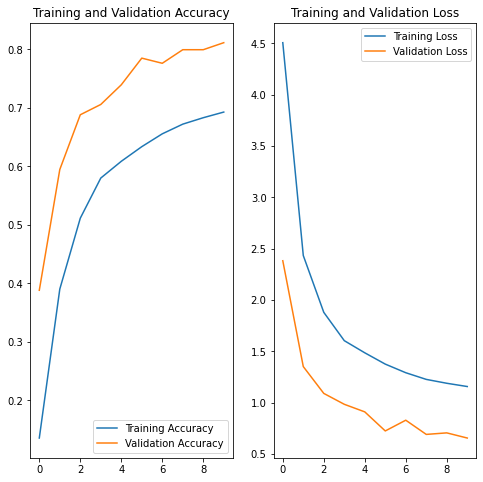

In [ ]:
acc = vgg16_history.history['accuracy']
val_acc = vgg16_history.history['val_accuracy']

loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> **Evaluate** the model





In [11]:
# BEST EPOCH
#vgg16_model.load_weights(checkpoint_filepath)
#predictions = vgg16_model.predict(test_ds)

results=vgg16_model.evaluate(test_ds,return_dict=True,verbose=1)

40/40 [==============================] - 14s 349ms/step - loss: 0.4556 - accuracy: 0.8784


#### InceptionV3

In [12]:

from tensorflow.keras.applications.inception_v3 import preprocess_input 


train_ds, val_ds, test_ds = pre_process((img_height, img_width),preprocess_input)


iv3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape = (img_height, img_width,3),
    #pooling=(2,2),
    classes=num_classes,
    classifier_activation="softmax",
)
for layer in iv3.layers:
    layer.trainable = False
x = Flatten()(iv3.output)


#Add the fully-connected layers 

x = Dense(528, activation='relu', name='fc1')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc2')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc3')(x)

#x = Dropout(0.1)(x)
x = Dense(num_classes, activation='softmax', name='predicts')(x)

incept_v3 = tf.keras.Model(inputs=iv3.input, outputs=x)

incept_v3.compile(optimizer=tf.keras.optimizers.Adagrad(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


incept_v3.summary()

incept_v3_history = incept_v3.fit(train_ds, validation_data = val_ds, epochs=epochs,
  callbacks=my_callbacks,
  batch_size=batch_size,
  verbose=1 )


incept_v3.save('inc_v3')

K.clear_session()


Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
______________________________________________________________________________________________

> **Evaluate** the model



In [17]:
# BEST EPOCH
#incept_v3.load_weights(checkpoint_filepath)

#predictions = incept_v3.predict(test_ds)
result = incept_v3.evaluate(test_ds)

40/40 [==============================] - 13s 314ms/step - loss: 0.3175 - accuracy: 0.9160


#### NASNetMobile


In [21]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input 


train_ds, val_ds, test_ds = pre_process((img_height, img_width),preprocess_input)


nnm = tf.keras.applications.NASNetMobile(
    include_top=False,
    weights="imagenet",
    input_shape = (img_height, img_width,3),
    #pooling=(2,2),
    classes=num_classes

)
for layer in nnm.layers:
    layer.trainable = False
x = Flatten()(nnm.output)


#Add the fully-connected layers 

x = Dense(528, activation='relu', name='fc1')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc2')(x)
x = Dropout(0.1)(x)
x = Dense(528, activation='relu', name='fc3')(x)
#x = Dropout(0.1)(x)
x = Dense(num_classes, activation='softmax', name='predicts')(x)

nnm_model = tf.keras.Model(inputs=nnm.input, outputs=x)

nnm_model.compile(optimizer=tf.keras.optimizers.Adagrad(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


nnm_model.summary()

nnm_model_history = nnm_model.fit(train_ds, validation_data = val_ds, epochs=epochs,
  callbacks=my_callbacks,
  batch_size=batch_size,
  verbose=1 )

K.clear_session()


Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0      

> **Evaluate** the model


In [22]:
# BEST EPOCH
nnm_model.save('nnm')
#nnm_model.load_weights(checkpoint_filepath)

#predictions = nnm_model.predict(test_ds)
result = nnm_model.evaluate(test_ds)

INFO:tensorflow:Assets written to: nnm/assets
40/40 [==============================] - 14s 360ms/step - loss: 0.4602 - accuracy: 0.8776


In [ ]:
from google.colab import files
!ls
files.download('nnm') 

### Compare All Models
>Custom Models comparision

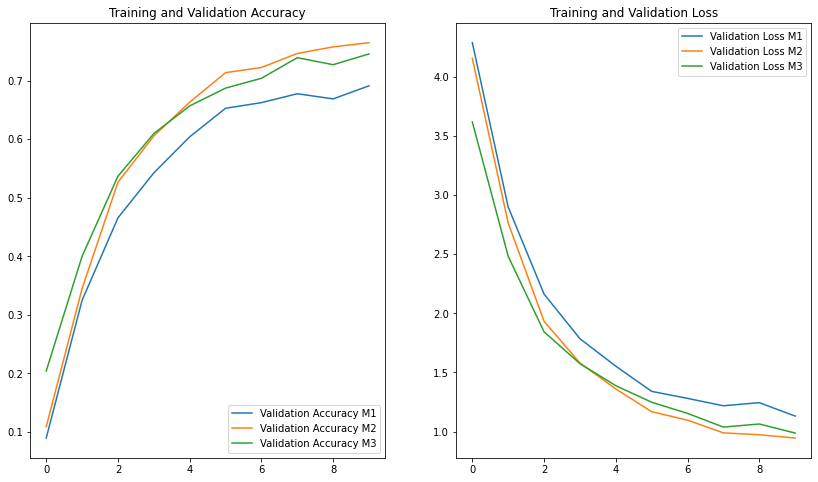

In [ ]:
val_acc1 = history1.history['val_accuracy']
val_acc2 = history2.history['val_accuracy']
val_acc3 = history3.history['val_accuracy']


val_loss1 = history1.history['val_loss']
val_loss2 = history2.history['val_loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, val_acc1, label='Validation Accuracy M1')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy M2')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy M3')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, val_loss1, label='Validation Loss M1')
plt.plot(epochs_range, val_loss2, label='Validation Loss M2')
plt.plot(epochs_range, val_loss3, label='Validation Loss M3')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()


> **Pré-trained** Models comparision

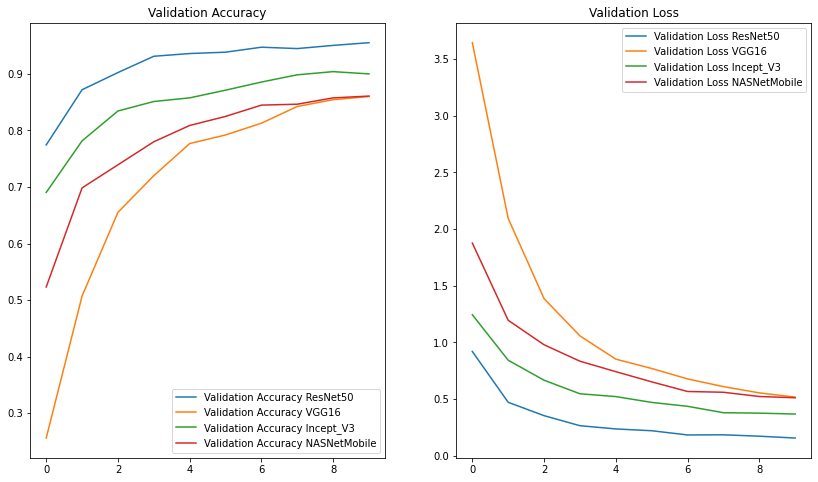

In [30]:

val_acc1 = resnet_history.history['val_accuracy']
val_acc2 = vgg16_history.history['val_accuracy']
val_acc3 = incept_v3_history.history['val_accuracy']
val_acc4 = nnm_model_history.history['val_accuracy']


val_loss1 = resnet_history.history['val_loss']
val_loss2 = vgg16_history.history['val_loss']
val_loss3 = incept_v3_history.history['val_loss']
val_loss4 = nnm_model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, val_acc1, label='Validation Accuracy ResNet50')
plt.plot(epochs_range, val_acc2, label='Validation Accuracy VGG16')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy Incept_V3')
plt.plot(epochs_range, val_acc4, label='Validation Accuracy NASNetMobile')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, val_loss1, label='Validation Loss ResNet50')
plt.plot(epochs_range, val_loss2, label='Validation Loss VGG16')
plt.plot(epochs_range, val_loss3, label='Validation Loss Incept_V3')
plt.plot(epochs_range, val_loss4, label='Validation Loss NASNetMobile')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()


 > Predict with  percent confidence

In [ ]:
'''
for i in range(0,1250):
    score = tf.nn.softmax(predictions[i])
    print(
        "{} :This image most likely belongs to {} with a {:.2f} percent confidence."
       .format(i,class_names[np.argmax(score)], 100 * np.max(score))
    )
'''

# GA - Genetic Algorithm 
> Algorithms for CNN optimization <br />
(Genetic Algorithm for finding best CNN architecture)


> Auxiliar Functions


In [ ]:
#calcula em que iteracoes é necessariso fazer o poling
def split_somaAnterior(x, n):
    l=[]
    if (x < n): # não é possivel dividir
        return l
        #print(-1)
    elif (x % n == 0): #se der para dividir em partes iguais
        for i in range(n):
            if i==0:
                l.append(x//n)
            else:
                l.append(l[i-1]+x//n)
            #print(x//n, end =" ")
    else: 
        zp = n - (x % n)
        pp = x//n
        for i in range(n):
            if(i>= zp):
                if (i==0):
                    l.append(pp + 1)
                else:
                    l.append(l[i-1]+ pp + 1)
                #print(pp + 1, end =" ")
            else:
                if (i==0):
                    l.append(pp)
                else:
                    l.append(l[i-1]+ pp )
                #print(pp, end =" ")
    return l

def convert_Pop_format(pop):
  arr1=[]
  arr2=[]
  arr3=[]
  arr4=[]
  arr5=[]
  arr6=[]
  arr7=[]
  for cnn in pop:
      arr1.append(cnn[0][0])
      arr2.append(cnn[0][1])
      arr3.append(cnn[0][2])
      arr4.append(cnn[0][3])
      arr5.append(cnn[1])
      arr6.append(cnn[2][0])
      arr7.append(cnn[2][1])
  a=np.array([arr1,arr2,arr3,arr4])
  b=np.array(arr5)
  c=np.array([arr6,arr7])
  return (a,b,c)

def check(elem,arr):
  for x in arr:
    if x == elem:
      return True 
  return False  

def calcula_distribuicaoNormal(media,desvio,n_times):
    s = np.random.normal(media, desvio,n_times)
    return int(np.average(s))
#valor entre 0 e 1.
def calcula_distribuicaoBeta(a,b,n_times):
  s = np.random.beta(a,b,n_times)
  return round(np.average(s),4)

### 1 - Definir os Cromossomas:

> Um **individuo** da população -> Uma `CNN`

> **Genes** - são as carateristicas e os parametros que vão ser otimizados.

In [ ]:
num_epochs,n_layers= 5,4 # Todas as CNN vão ter 1 epochs e 4 layes conv2D
input_shape=(224, 224,3) #input das CNN
genes={
    'nfilters':[32,64,128,180,200,256],#,300,400],
    'kernel_size':[(3,3)], #,(5,5),(7,7)]
    'padding':['same'],
    'activation':['relu'],
    'pool_size':[(2,2)],
    'strides':[(2,2)],
    'nlayers_Pooling': [n_layers]#[x for x in range(n_layers+1) if x > n_layers/3]
    #'ndense':[256,512,528,1024] #300,400,500,512,600,750,1024,4096]
    #max pooling também pode ser considerado como um gene . A posição de onde este é feito é calculada através de uma distribuição normal, que depois é feito um split igualmente espaçado.
}
#function to get Genes 
def g(x,y):
  if x==0:
    return genes['nfilters'][int(y)]
  elif x==1:
    return genes['kernel_size'][int(y)]
  elif x==2:
    return genes['padding'][int(y)]
  elif x==3:
    return genes['activation'][int(y)]
  elif x==4:
    return genes['pool_size'][int(y)]
  elif x==5:
    return genes['strides'][int(y)]
  elif x==6:
    return genes['nlayers_Pooling'][int(y)]


In [ ]:
class CNN(Sequential): 
    def __init__(self,nfilters,sfilters,padd,act,pool,stride,nlayer_pool):
        super().__init__()#(name=name_model)
        size=len(nfilters) # numero  de camadas conv
        #1 camada conv2D, só para passar o input shape.
        self.add(Conv2D(filters=g(0,nfilters[0]),kernel_size=g(1,sfilters[0]),padding=g(2,padd[0]),activation=g(3,act[0]),input_shape=input_shape))
        self.add_maxpooling2D(g(4,pool[0]),g(5,stride[0]))
        aux=1
        #VERSAO PARA ALTERAR O Nº de  POOLS.
        #l2=split_somaAnterior(size,nlayer_pool) # calcula as iteracoes de pooling
        #if (check(1,l2)) :
        #  self.add_maxpooling2D(g(4,pool[0]),g(5,stride[0]))
        #  aux+=1
        #print(l2)
        #for i  in range(1,size):
        #  self.add_conv(g(0,nfilters[i]),g(1,sfilters[i]),
        #                g(2,padd[i]),g(3,act[i])) 
        #  if check(i+1,l2) :
        #      self.add_maxpooling2D(g(4,pool[aux]),g(5,stride[aux]))
        #      aux+=1
        for i  in range(1,size):
          self.add_conv(g(0,nfilters[i]),g(1,sfilters[i]),
                        g(2,padd[i]),g(3,act[i])) 
          self.add_maxpooling2D(g(4,pool[i]),g(5,stride[i]))
        
        self.add(Flatten())
        self.add(Dense(528,activation='relu'))
        #self.add(Dense(264,activation='relu'))
        self.add(Dropout(0.1))
        self.add(Dense(units = num_classes,activation='softmax'))
        self.model_compile('adam','categorical_crossentropy',['accuracy'])
        self.summary()
    def add_conv(self,filter,kernel_size,padding,activation):
        self.add(Conv2D(filters=int(filter),kernel_size=kernel_size,padding=str(padding),activation=str(activation)))
    def add_maxpooling2D(self,pool_size,strides):
        self.add(MaxPooling2D(pool_size=pool_size,strides=strides))
    def add_dropout(self,rate):
        self.add(Dropout(rate=rate))
    def add_dense(self,filters,f_activation):
        self.add(Dense(units =filters,activation=f_activation))
    def model_compile(self,f_opt,f_loss,list_metrics):
        self.compile(optimizer=f_opt,loss=f_loss,metrics=list_metrics)

### 2 - Fitness function:

> Responsável pela avaliação de um cromosoma da população. No entanto, aqui é avaliado toda a população para facilitar a compreensão.

In [ ]:

def fitness(pop,X,Y,epochs,number_filters,parents,best_m):
    pop_acc = []
    best_model = best_m
    best_acc = -1
    aux=False
    i=0#iteracao
    while (i<len(pop[1])): 
      if not aux and parents != np.array([]):  # verifica se é a primeira geração
        for acc_p1 in parents[1]: #adciona os acc dos pais , pois já foram executados na geracao anterior.
          pop_acc.append(acc_p1)
          i+=1
        aux=True
      model = CNN(pop[0][0][i],pop[0][1][i],pop[0][2][i],pop[0][3][i],pop[2][0][i],pop[2][1][i],pop[1][i])
      print(''.join(["Fitting Model ",str(i+1)," ..." ]))
      H = model.fit(X,validation_data=Y,epochs=epochs,callbacks=my_callbacks,steps_per_epoch=551,verbose=1)
      #model.load_weights(checkpoint_filepath)
      print("Evaluating:")
      acc =  model.evaluate(test_ds, verbose=1, return_dict=True)['accuracy']
      pop_acc.append(acc)
      if (acc > best_acc): #guarda o melhor modelo e a sua accuracy.
        best_acc = acc
        best_model = model
      K.clear_session()
      i+=1
    return (np.array(pop_acc),best_model)



### 3 - Selection:
> Selecting the highest accuracy Chromosomes (**parents**)

In [ ]:
def select_parents(pop,nparents,fitness):
    parents = [] # len de cada elemento da lista
    acc_parents=[] 
    for i in range(nparents):
        best = np.argmax(fitness) # obter a posição do maior elemento da lista.
        a = np.array([pop[0][0][best],pop[0][1][best],pop[0][2][best],pop[0][3][best]]) #conv2D config
        b = pop[1][best]                                                                #numero pools
        c = np.array([pop[2][0][best],pop[2][1][best]])                                 #Maxpooling config
        parents.append((a,b,c))
        acc_parents.append(fitness[best])
        fitness[best] = -99999
    return (parents,acc_parents)

### 4 - Crossover:
>  Creating the new childs using the selected best N networks

In [ ]:
#Gera uma matriz com  os genes das duas matrizes, linha1 da matriz 1 com linha 2 da matriz 2 etc.
def alternate_genes(matrix1,matrix2):
  matrix3=np.zeros((matrix1.shape[0],matrix1.shape[1]), dtype=int) 
  for i in range(0, matrix1.shape[0]):
    for j in range(0, matrix1.shape[1]):
      if (j%2 == 0):   
        matrix3[0][j] = matrix1[0][j]
      else:
        matrix3[0][j] = matrix2[0][j]
  return matrix3


In [ ]:
def crossover(parents,pop_size):
    nparents = len(parents)
    nchild = pop_size - nparents #pop_size - len da lista
    
    childs = []
    for i in range(nchild):
        first = i % nparents
        second = (i+1) % nparents
        f_conv1=parents[first][0]  #camada Conv2D  Pai1
        f_conv2=parents[second][0] #camada Conv2D  Pai2
        f_pool1=parents[first][2]  #camada Pooling Pai1
        f_pool2=parents[second][2] #camada Pooling Pai2

        c1 = alternate_genes(f_conv1,f_conv2)
        c2= parents[first][1]
        c3 = alternate_genes(f_pool1,f_pool2)
        
        childs.append(np.array((c1,c2,c3)))
    return childs

### 5 - Mutation:
> Randomly changing genes (Epoch and neurons)


In [ ]:
def mutation(childs):
    #print(childs[0][0].shape[0])
    #print(len(childs))
    for c in childs:
      #print(c[0])
      tam=len(c[0][0])
      a=np.random.randint(0,tam,tam//2,dtype=np.uint8)
      for i in range(0,tam): # conv
        val=g(0,c[0][0][i])
        tam_gen=len(genes['nfilters'])
        if i in a:
        #if (i < tam/2):
          x=calcula_distribuicaoNormal(val,val/2,2)
          genes['nfilters'].append(x)
          c[0][0][i]=int(tam_gen)
        #else:
        #  a=np.random.randint(0,5,2,dtype=np.uint8)
        #  per=calcula_distribuicaoBeta(a[0]+1,a[1]+1,1)
        #  if (per>0.3): 
        #    x= c[0][0][i] + per*c[0][0][i]
        #  else:
        #    x= c[0][0][i] - per*c[0][0][i]

      #    genes['nfilters'].append(x)
       #   c[0][0][i]=int(tam_gen)

      #print(c[0])
    #    for j in range(0,childs[i][0].shape[0]):
            #ind= np.random.randint(0,childs[i][0].shape[1] ,dtype=np.uint8)
   #         print(childs[i][0][j])
   #         print(" --- ")
         # [] = 
      #print(childs)
        #calcula_distribuicaoNormal(64,32))
    return childs

### 6 - Generation:
> 6.1 - Define Initial population<br />
> 6.2  - Number Max of generations

In [ ]:
#Given the  possible parameters to returns randomly generated population
def generate_population(pop_size,nlayers,max_nfilters,max_sfilters,max_padd,max_act,max_pool,max_strides,max_pos):
    #gera uma matriz para todas valores dos filtros, onde a linha 0 corresponde à primeira geração...
    pop_nlayers     = np.random.randint(0,max_nfilters,(pop_size,nlayers), dtype=np.uint8) 
    pop_sfilters    = np.random.randint(0,max_sfilters,(pop_size,nlayers), dtype=np.uint8)
    pop_padd        = np.random.randint(0,max_padd,(pop_size,nlayers), dtype=np.uint8)
    pop_act         = np.random.randint(0,max_act,(pop_size,nlayers), dtype=np.uint8)
    pop_pos_layersP = np.random.randint(0,max_pos,(pop_size), dtype=np.uint8)
    
    pop_pool = []
    pop_strides =[]
    
    #substituir os valorses logo pelas posições do dict genes
    f = lambda x: genes['nlayers_Pooling'][int(x)]
    pop_pos_layersP = np.random.randint(0,max_pos,(pop_size), dtype=np.uint8)
    pop_pos_layersP = np.array(list(map(f, pop_pos_layersP)))


    for x in  pop_pos_layersP:
      pop_pool_aux  = np.random.randint(0,max_pool,(x), dtype=np.uint8)
      pop_pool.append(pop_pool_aux)
      pop_strides_aux= np.random.randint(0,max_strides,(x), dtype=np.uint8)
      pop_strides.append(pop_strides_aux)
    
    pop_conv=np.array([pop_nlayers,pop_sfilters,pop_padd,pop_act])
    pop_max_p = np.array([pop_pool, pop_strides])
    pop_total=(pop_conv,pop_pos_layersP,pop_max_p) #triplo
  
    return pop_total

In [ ]:
  #numero de gerações
generation_size=5 

### 7 - Termination criteria:
> If some chromosome(CNN) accuracy is **greater or equal** than the `threshold` accuracy or value of generations is equals to , stop the algorithm.

In [ ]:
#se existir algum pai que é tem mais acc que o threshold .
def termination(fitness,threshold,gen):
  best = max(fitness) #np.amax(fitness)
  if best >= threshold or gen >= generation_size: 
      return True
  return False


### 8 - Run:
> Recursive Process until termination function give true


In [ ]:
pop_size=6 # tamanho da população
th=0.9     # threshold to stop


#possible choices to Genes
pc_filtes   = len(genes['nfilters'])
pc_kernel   = len(genes['kernel_size'])
pc_padd     = len(genes['padding'])
pc_act      = len(genes['activation'])
pc_pool     = len(genes['pool_size'])
pc_strides  = len(genes['strides'])
pc_pos_Pool = len(genes['nlayers_Pooling'])

pop = generate_population(pop_size,n_layers,pc_filtes,pc_kernel,pc_padd,pc_act,pc_pool,pc_strides,pc_pos_Pool)  # população inicial,  
#6 é numero de posições possiveis escolhas no array de genes! e 1 de kernels
gen=1                              #geração atual
print(pop)
paren=np.array([])                 #Guardas os pais da geração
best_model=tf.keras.models.Model() #Guarda o melhor model
while (True):
  print(str(gen)+"º Geration\n")
  (fit_acc,best_model) = fitness(pop,train_ds,val_ds,num_epochs,n_layers,paren,best_model) # fitness function
  if termination(fit_acc,th,gen):                                         # termination criteria
      print(best_model.summary())
      break
  #(fit_acc) = [0.4,0.3,0.2,0.1]
  paren  = select_parents(pop,(pop_size // 2),fit_acc) # Select bests individuals(parents)
  childs = crossover(paren[0],pop_size)                # Create childs with parents
  new_childs = mutation(childs)                     # change some parameters randomly

  pop_aux = np.concatenate((paren[0],new_childs),axis=0)   # justar os parents com os novos filhos.
  pop=convert_Pop_format(pop_aux)
  #print(pop)
  gen+=1

(array([[[1, 4, 5, 4],
        [1, 3, 0, 1],
        [5, 1, 3, 4],
        [2, 3, 4, 4],
        [3, 3, 2, 3],
        [0, 2, 2, 4]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8), array([4, 4, 4, 4, 4, 4]), array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8))
1º Geration

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


Epoch 1/5
551/551 [==============================] - 177s 319ms/step - loss: 5.2507 - accuracy: 0.0262 - val_loss: 4.3326 - val_accuracy: 0.1008
Epoch 2/5
551/551 [==============================] - 174s 316ms/step - loss: 4.1954 - accuracy: 0.1304 - val_loss: 3.5758 - val_accuracy: 0.2152
Epoch 3/5
551/551 [==============================] - 174s 316ms/step - loss: 3.5630 - accuracy: 0.2273 - val_loss: 3.1505 - val_accuracy: 0.2856
Epoch 4/5
551/551 [==============================] - 174s 316ms/step - loss: 3.1317 - accuracy: 0.3068 - val_loss: 2.8869 - val_accuracy: 0.3240
Epoch 5/5
551/551 [==============================] - 174s 316ms/step - loss: 2.7248 - accuracy: 0.3793 - val_loss: 2.3950 - val_accuracy: 0.4152
Evaluating:
40/40 [==============================] - 2s 52ms/step - loss: 2.3443 - accuracy: 0.4320
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packa

Epoch 1/5
551/551 [==============================] - 177s 319ms/step - loss: 5.3394 - accuracy: 0.0148 - val_loss: 4.4885 - val_accuracy: 0.0720
Epoch 2/5
551/551 [==============================] - 175s 318ms/step - loss: 4.3854 - accuracy: 0.0991 - val_loss: 3.6309 - val_accuracy: 0.1760
Epoch 3/5
551/551 [==============================] - 175s 318ms/step - loss: 3.6267 - accuracy: 0.2084 - val_loss: 3.0568 - val_accuracy: 0.2744
Epoch 4/5
551/551 [==============================] - 176s 319ms/step - loss: 3.0640 - accuracy: 0.3137 - val_loss: 2.5359 - val_accuracy: 0.4064
Epoch 5/5
551/551 [==============================] - 175s 318ms/step - loss: 2.5321 - accuracy: 0.4100 - val_loss: 2.1543 - val_accuracy: 0.4744
Evaluating:
40/40 [==============================] - 2s 52ms/step - loss: 2.0385 - accuracy: 0.4880
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (

In [ ]:
print(best_model.summary())

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 27)      756       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 27)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     31232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 111)       127983    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 111)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 299)       299000  

In [ ]:
# accuracy of last population
print(fit_acc)

[0.48800001 0.47440001 0.46560001 0.46160001 0.4368     0.336     ]
